In [1]:
import pandas as pd
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [2]:
# import nltk
# nltk.download("stopwords")
# import nltk
# nltk.download('wordnet')

In [3]:
df = pd.read_csv("./tweet_emotions.csv")
df.head()

,text,label
0,@tiffanylue i know i was listenin to bad habi...,empty
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,@dannycastillo We want to trade with someone w...,neutral


In [7]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    ## Next step is text-normalization
    
    # Text normalization includes many steps.
    
    # Each function below serves a step.
    
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words
    
    # All above functions work on word tokens we need a tokenizer
    
    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)
    
    
    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    import re

    
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]
    
    
    # return processed df
    return df

In [8]:
print("Before Text Preprocessing")
display(df.head()[['text']])
processed_df = text_preprocessing_platform(df, 'text', remove_stopwords=False)
print("After Text Preprocessing")
display(processed_df.head()[['text']])

Before Text Preprocessing


,text
0,tiffanylue know listenin bad habit earlier sta...
1,layin n bed headache ughhhh waitin call
2,funeral ceremony gloomy friday
3,want hang friends soon
4,dannycastillo want trade someone houston ticke...


After Text Preprocessing


,text
0,tiffanylue know listenin bad habit earlier sta...
1,layin n bed headache ughhhh waitin call
2,funeral ceremony gloomy friday
3,want hang friends soon
4,dannycastillo want trade someone houston ticke...


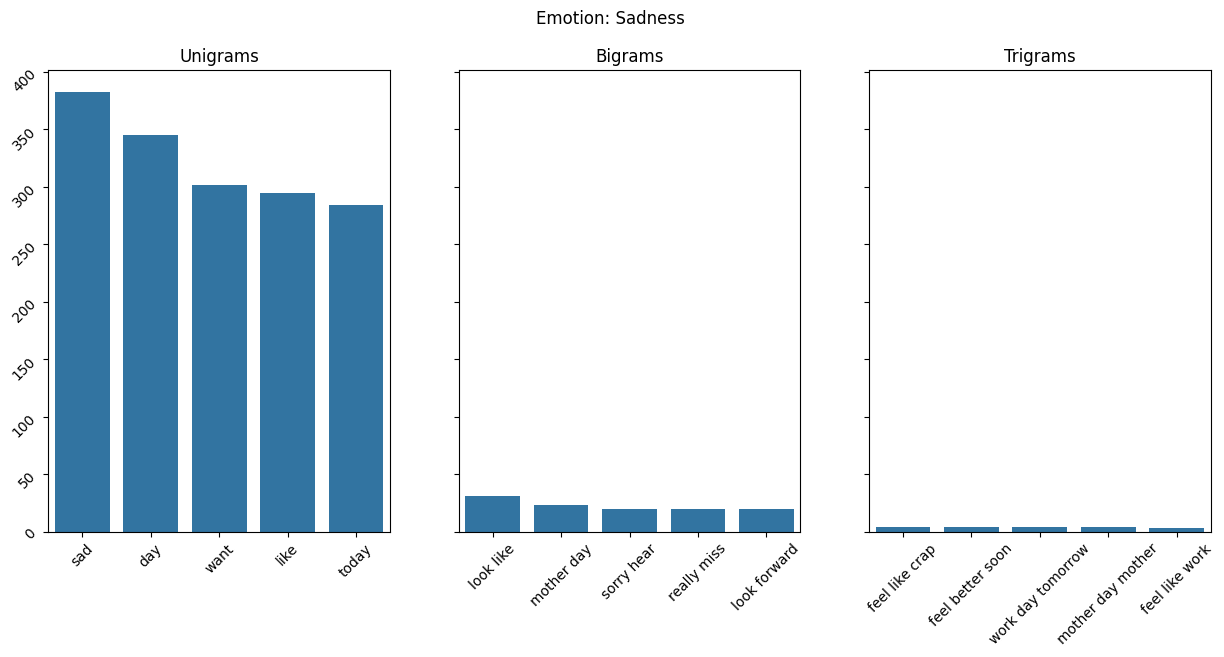

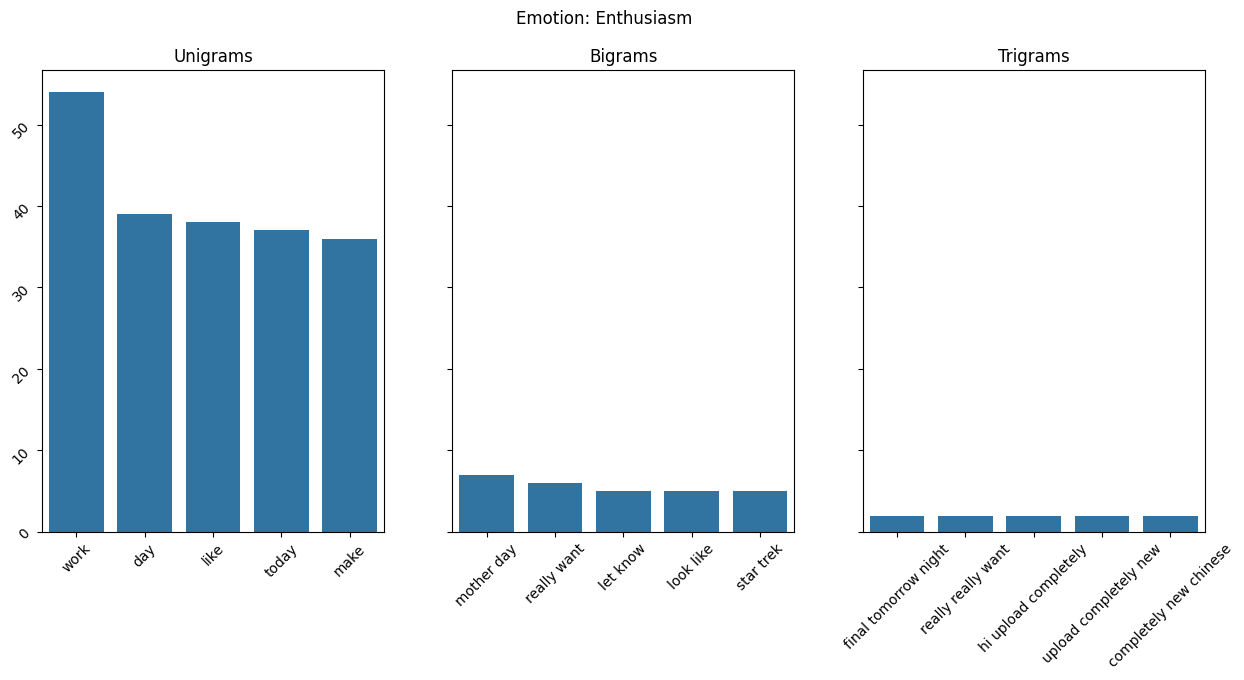

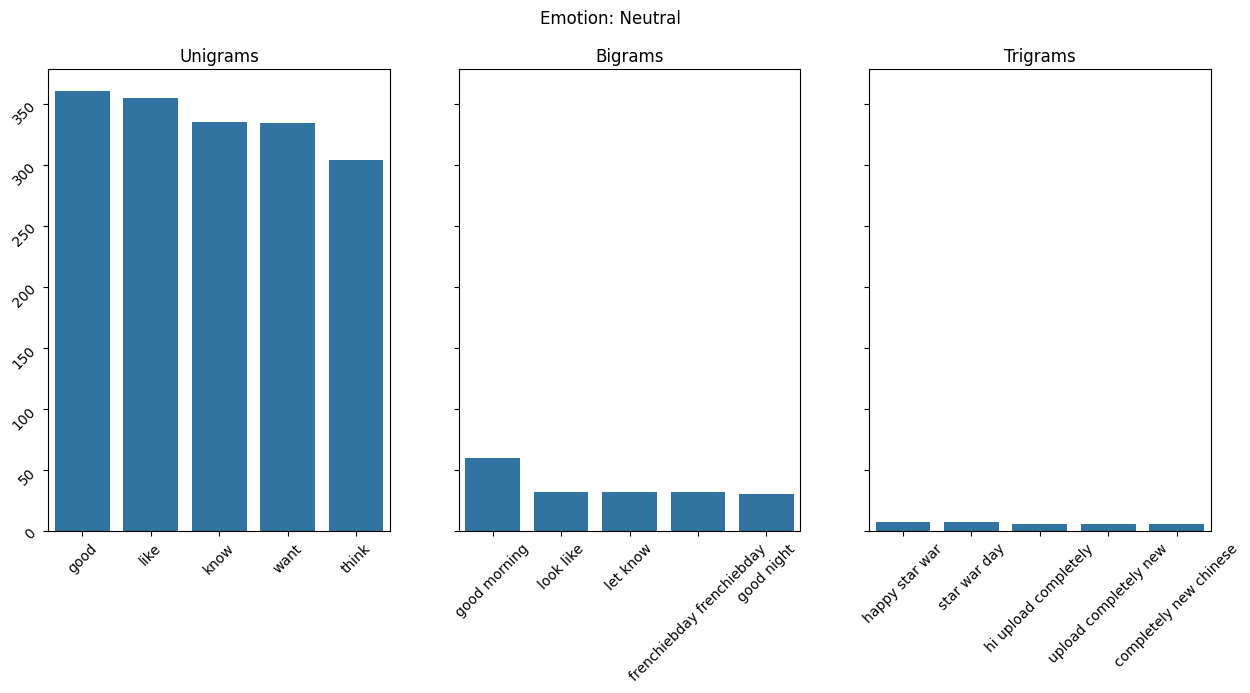

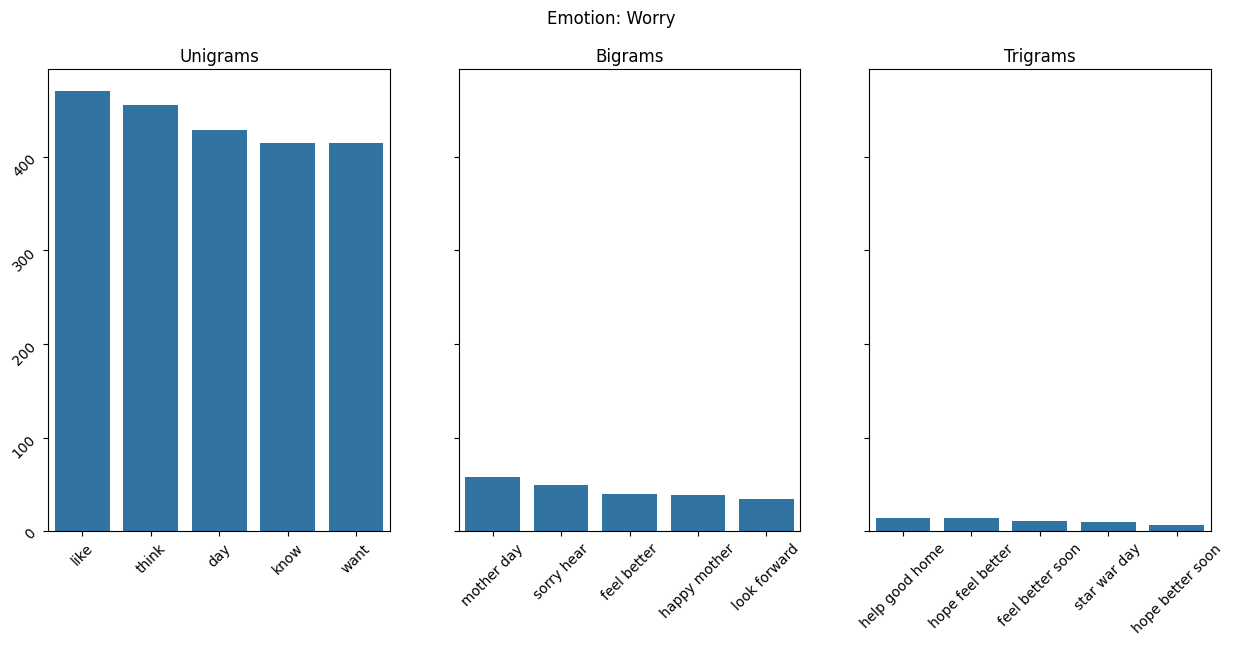

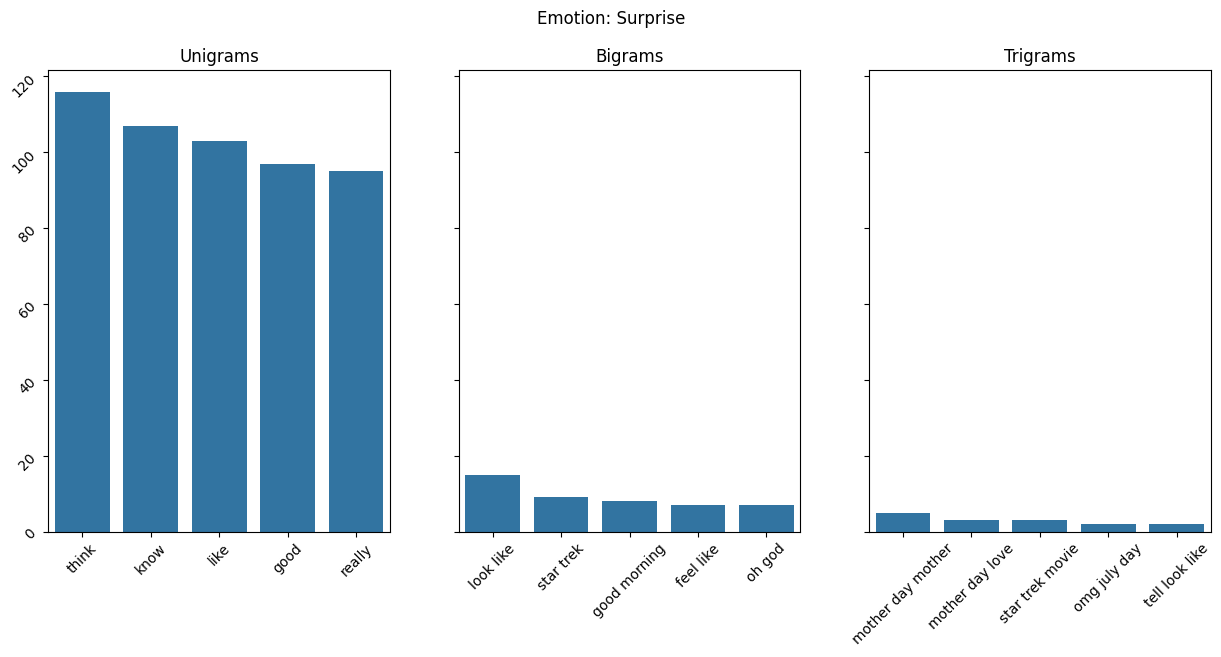

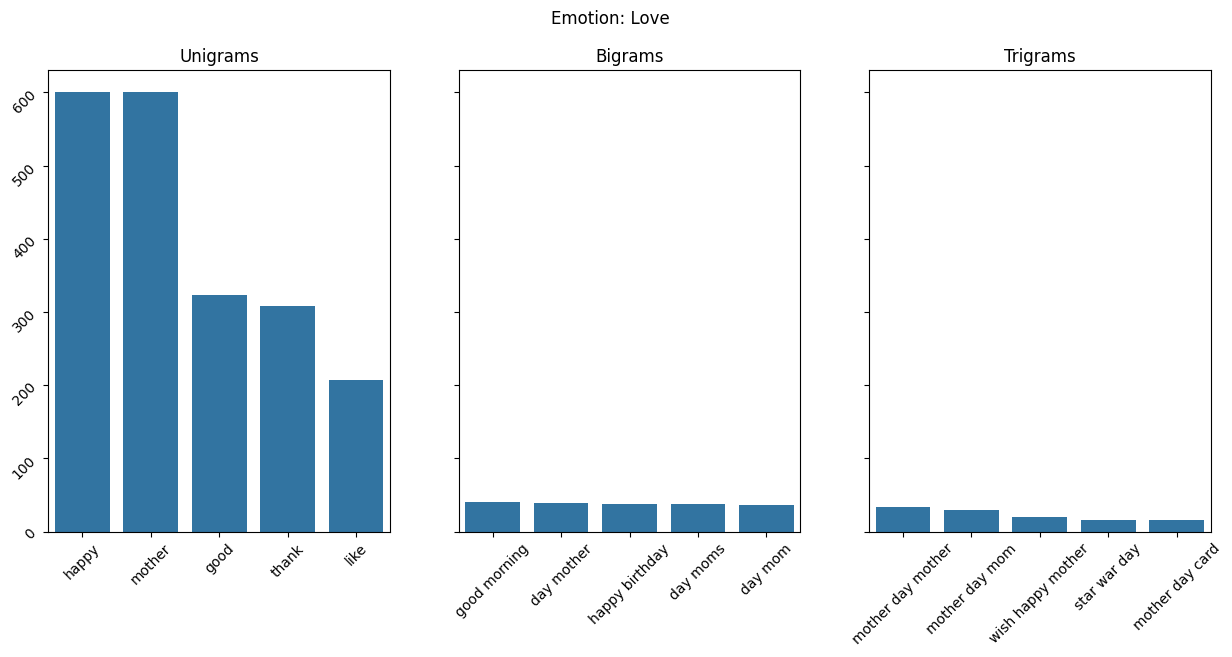

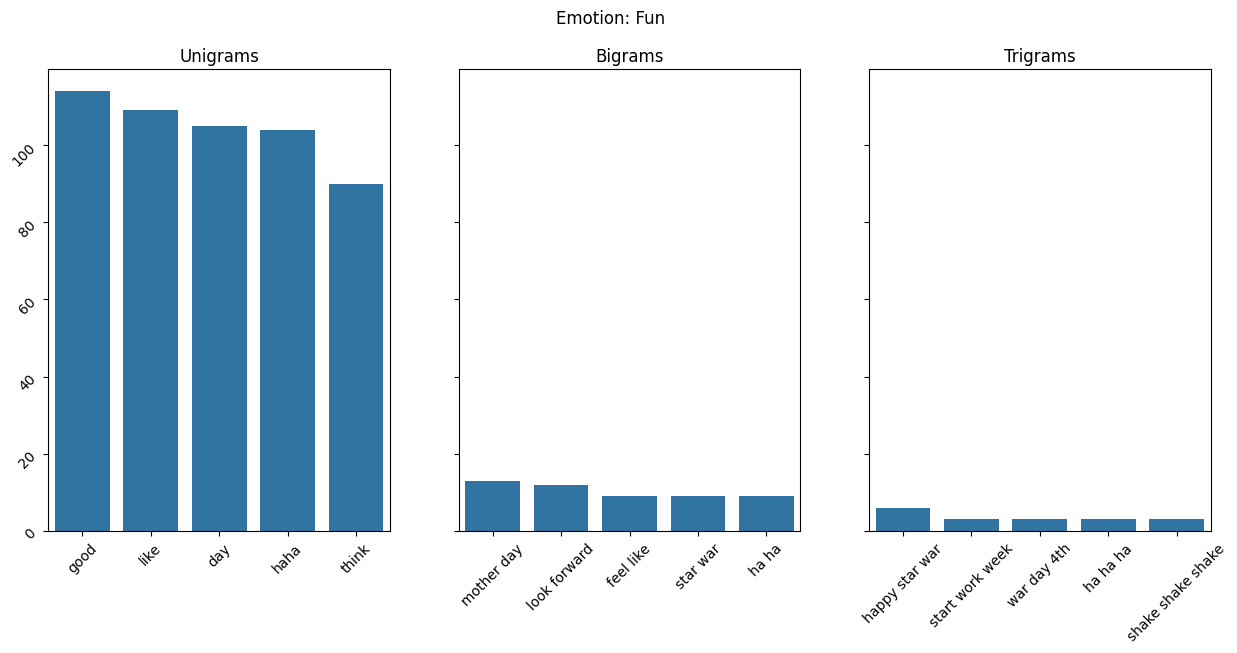

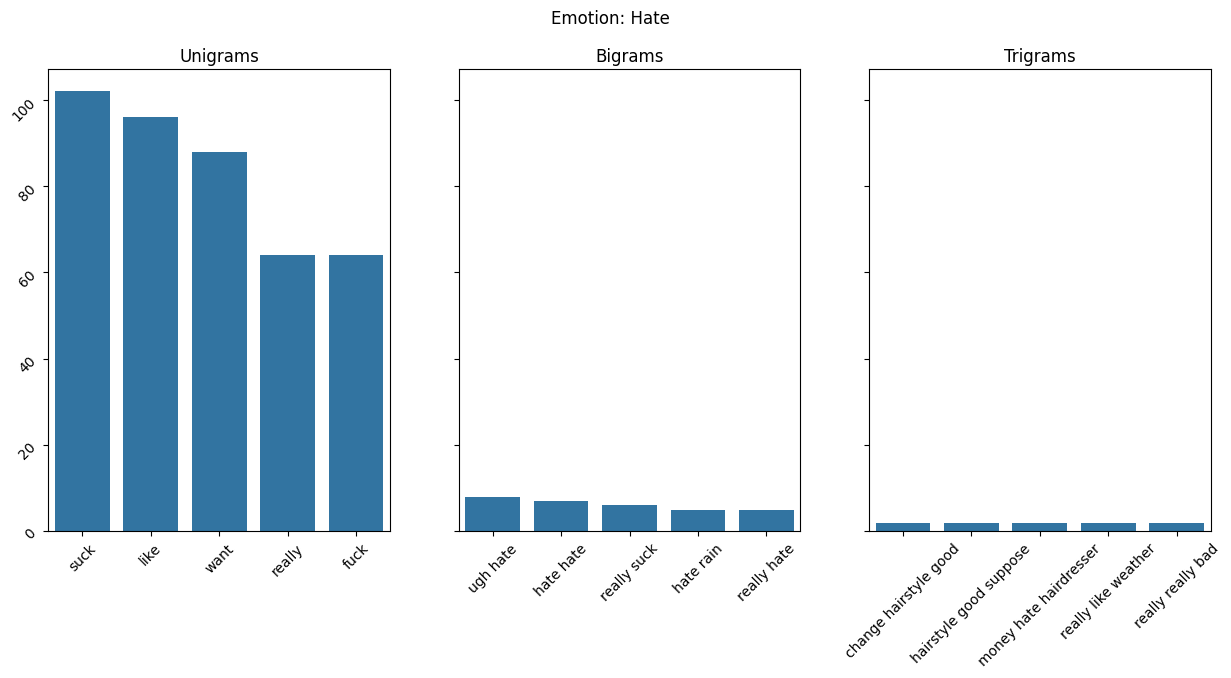

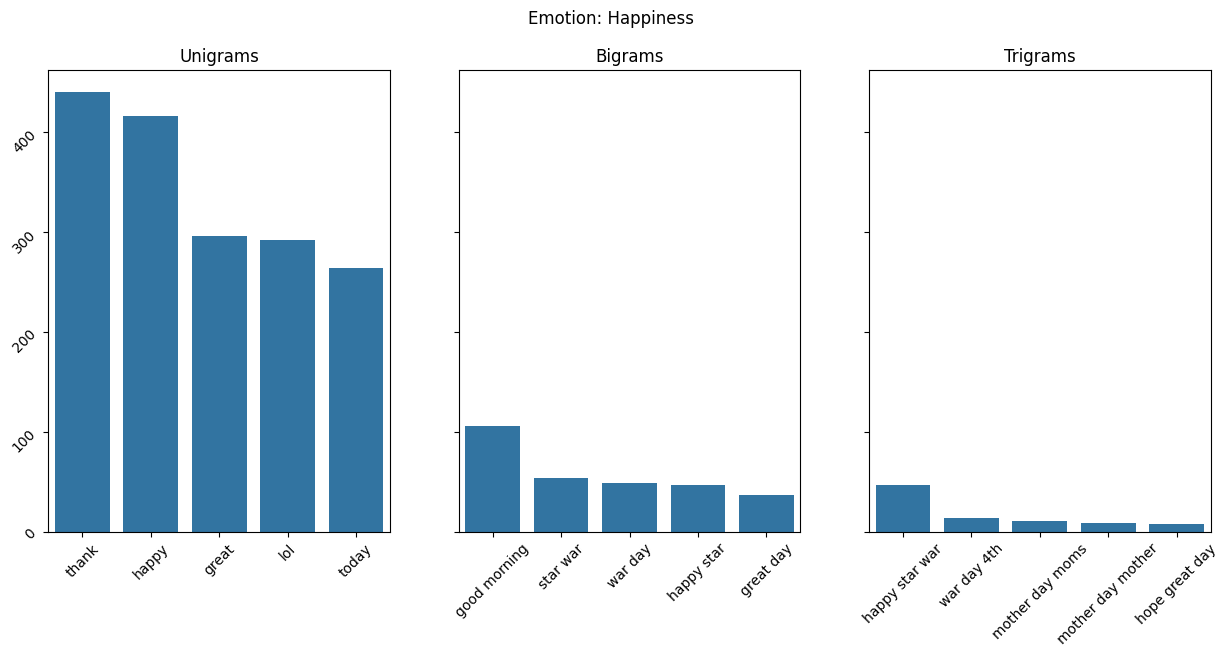

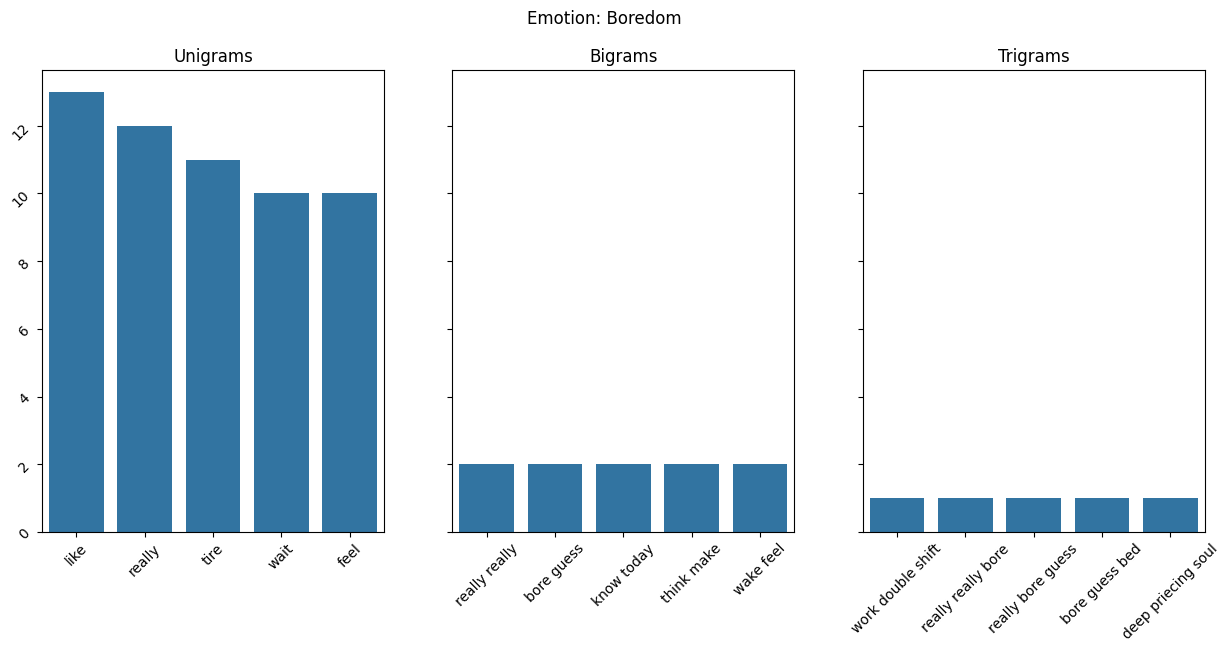

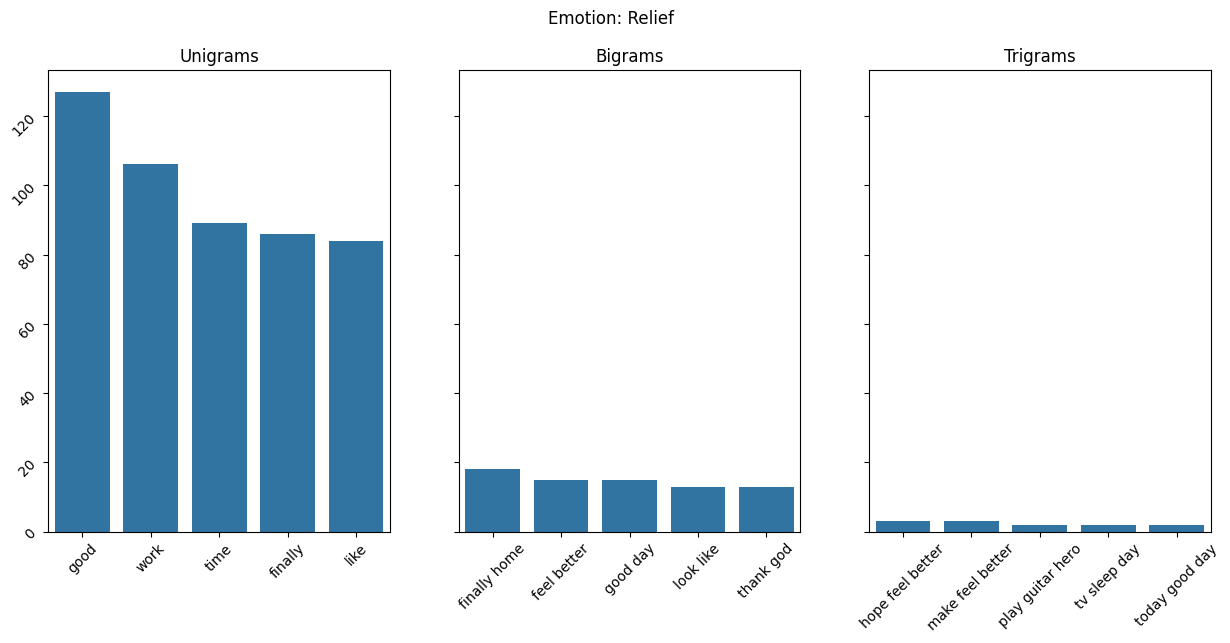

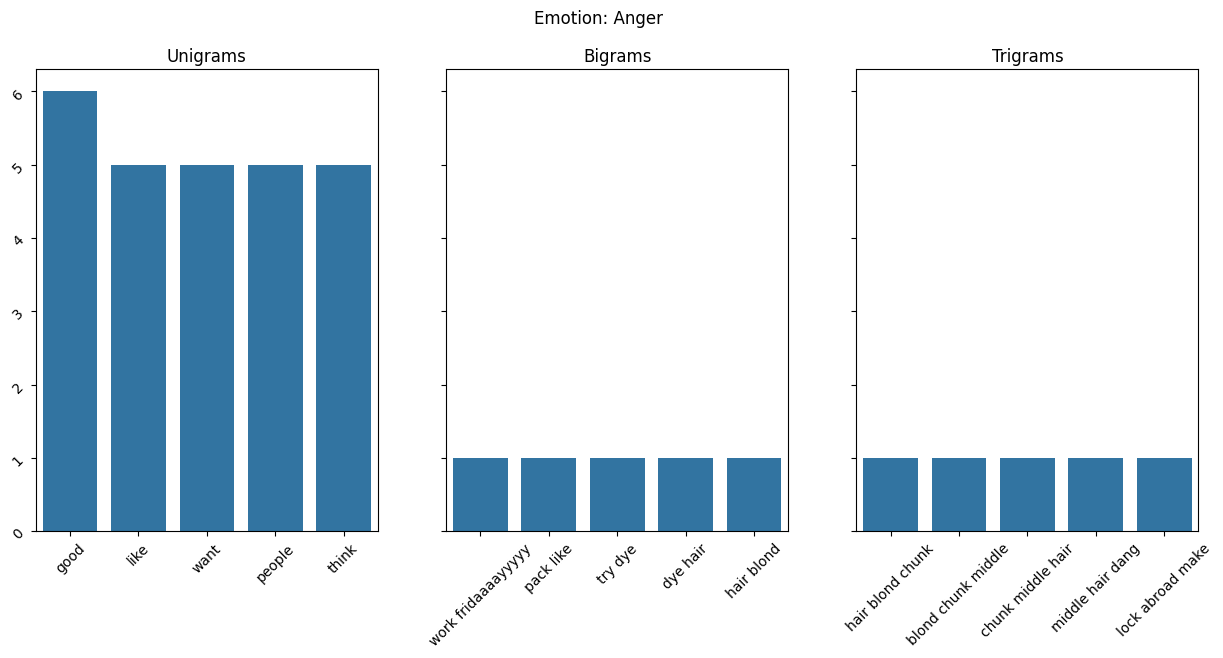

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

def get_top_n_gram(corpus, ngram_range, n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Specify the emotions
emotions = ['sadness', 'enthusiasm', 'neutral', 'worry', 'surprise', 'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger']

# Loop through each emotion
for emotion in emotions:
    emotion_data = processed_df[processed_df['label'] == emotion]['text']

    # Calculate unigrams, bigrams, and trigrams
    unigrams = get_top_n_gram(emotion_data.values, (1, 1), 7)[2:]
    bigrams = get_top_n_gram(emotion_data.values, (2, 2), 7)[2:]
    trigrams = get_top_n_gram(emotion_data.values, (3, 3), 7)[2:]

    # Visualize the n-grams
    fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
    fig.suptitle(f'Emotion: {emotion.capitalize()}')

    sns.barplot(x=list(dict(unigrams).keys()), y=list(dict(unigrams).values()), ax=axes[0])
    axes[0].set_title('Unigrams')
    axes[0].tick_params(labelrotation=45)

    sns.barplot(x=list(dict(bigrams).keys()), y=list(dict(bigrams).values()), ax=axes[1])
    axes[1].set_title('Bigrams')
    axes[1].tick_params(labelrotation=45)

    sns.barplot(x=list(dict(trigrams).keys()), y=list(dict(trigrams).values()), ax=axes[2])
    axes[2].set_title('Trigrams')
    axes[2].tick_params(labelrotation=45)


    # Show the plots
    plt.show()


In [10]:
processed_df.to_csv('processed_data.csv', index=False)